## 1. Классификация твитов: Trump vs. Trudeau
<p>А как насчет классифицировать тексты твитов? В этом блокноте рассмотрим классификацию текстов в социальных сетях, исследуя, как правильно классифицировать твиты двух известных североамериканских политиков: Дональда Трампа и Джастина Трюдо.</p>
<p><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/President_Donald_Trump_and_Prime_Minister_Justin_Trudeau_Joint_Press_Conference%2C_February_13%2C_2017.jpg/800px-President_Donald_Trump_and_Prime_Minister_Justin_Trudeau_Joint_Press_Conference%2C_February_13%2C_2017.jpg" alt="Donald Trump and Justin Trudeau shaking hands." height="100" width="180"></p>
<p><a href="https://commons.wikimedia.org/wiki/File:President_Donald_Trump_and_Prime_Minister_Justin_Trudeau_Joint_Press_Conference,_February_13,_2017.jpg">Photo Credit: Executive Office of the President of the United States</a></p>
<p>Твиты создают проблемы при обработке естественного языка, так как они являются более короткими текстами и существует также множество платформенно-специфичных соглашений, которые могут доставить проблемы: упоминания, #хэштеги, эмодзи, ссылки и сокращенные фразы ... Как преодолеть эти проблемы и создать полезный классификатор для этих двух твиттеров?</p>
<p>Для начала мы импортируем все необходимые нам инструменты из scikit-learn. Нам нужно будет правильно векторизовать наши данные (<code>CountVectorizer</code> and <code>TfidfVectorizer</code>). И мы также должны импортировать некоторые модели, включая <code>MultinomialNB</code> from the <code>naive_bayes</code> module, <code>LinearSVC</code> from the <code>svm</code> module and <code>PassiveAggressiveClassifier</code> from the <code>linear_model</code> module. В конце нам понадоятся  <code>sklearn.metrics</code>, <code>train_test_split</code> и <code>GridSearchCV</code>  из модуля <code>model_selection</code> для оценки и оптимизации нашей модели.</p>

<p>

Import CountVectorizer and TfidfVectorizer from sklearn.feature_extraction.text.
Import train_test_split from sklearn.model_selection.
Import MultinomialNB from sklearn.naive_bayes.
Import LinearSVC from sklearn.svm.
Import metrics from sklearn.
</p>

In [2]:
# Установить для воспроизводимости результатов
import random; random.seed(53)

# Импортируем неообходимые модули из sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [3]:
# это вспомогательные функции для отрисовки диаграмм

from matplotlib import pyplot as plt
import numpy as np
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          figure=0):
    """
    See full source and example:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """ 
    plt.figure(figure)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def plot_and_return_top_features(classifier, vectorizer, top_features=20):
    """
    Plot the top features in a binary classification model and remove possible overlap.

    Adapted from https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
    and https://stackoverflow.com/a/26980472 by @kjam
    """
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names_out()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:top_features]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-top_features:]
    top_coefficients = np.hstack([topn_class1, topn_class2])
    if set(topn_class1).union(topn_class2):
        top_coefficients = topn_class1
        for ce in topn_class2:
            if ce not in topn_class1:
                top_coefficients.append(x)

    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in [tc[0] for tc in top_coefficients]]
    plt.bar(np.arange(len(top_coefficients)), [tc[0] for tc in top_coefficients], color=colors)
    plt.xticks(np.arange(len(top_coefficients)),
               [tc[1] for tc in top_coefficients], rotation=60, ha='right')
    plt.show()
    return top_coefficients


## 2. Transforming our collected data
<p>Для начала давайте начнем с корпуса твитов, которые были собраны в ноябре 2017 года. Они доступны в формате CSV. Мы будем использовать Pandas DataFrame, чтобы импортировать данные и передать их в scikit-learn для дальнейшей обработки.</p>
<p>Поскольку данные были собраны через API Twitter и не разделены на тестовые и обучающие наборы, нам нужно будет сделать это. Давайте используем <code>train_test_split()</code> с параметром  <code>random_state=53</code> и размером тестовой выборки равной 0.33. Это гарантирует, что у нас будет достаточно тестовых данных, и мы получим одинаковые результаты независимо от того, где и когда мы запустим этот код..</p>
<p>
Данные расположенны в папке dataset файл tweets.csv
</p>

In [4]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd

# Загрузите данные
tweet_df = pd.read_csv('tweets.csv')

# Выберите целевую переменную
y = tweet_df['author']

# Разделите данные на тестовую и обучающую выборки
X_train, X_test, y_train, y_test = train_test_split(tweet_df['status'], y, test_size=0.33, random_state=53, stratify=y)

## 3. Векторизация твитов
<p>У нас есть все необходимые данные для обучения и тестирования, но нам нужно создать векторные представления твитов, чтобы применить машинное обучение..</p>
<p>Для этого мы воспользуемся классами <code>CountVectorizer</code> и <code>TfidfVectorizer</code>, которые нам сначала нужно будет подогнать под данные..</p>
<p>Как только это будет завершено, мы сможем начать моделирование с использованием новых векторизованных твитов</p>


In [6]:
# Инициализировать count vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

# Создать векторизированое представление для тестовой и обучающей выборки на основе count vectorizer
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# Инициализировать tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Создать векторизированое представление для тестовой и обучающей выборки на основе tfidf vectorizer
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

## 4. Обучение мультиномиальной наивной байесовской модели
<p>Теперь, когда у нас есть данные в векторизованной форме, мы можем обучить первую модель. Исследуйте с помощью модели Multinomial Naive Bayes оба векторных представления <code>CountVectorizer</code> и <code>TfidfVectorizer</code>. Что будет работать лучше? Почему?</p>
<p>Для оценки точности вывести оценки точности тестовых наборов для обеих моделей.</p>


Обучите и протестируйте байесовские модели с использованием векторов TF-IDF и CountVectorizer, чтобы увидеть, как они работают.


In [7]:
# Создать модель MulitnomialNB на основе TF-IDF
tfidf_nb = MultinomialNB()

# ... Обучить модель ...
tfidf_nb.fit(tfidf_train, y_train)
# Пооверьте предсказание модели на тестовых TF-IDF данных
tfidf_nb_pred = tfidf_nb.predict(tfidf_test)

# Рассчитайте точность ваших прогнозов
tfidf_nb_score = metrics.accuracy_score(y_test, tfidf_nb_pred)

# Создать модель MulitnomialNB на основе CountVectorizer
count_nb = MultinomialNB()

# ... Обучить модель ...
count_nb.fit(count_train, y_train)
# Пооверьте предсказание модели на тестовых CountVectorizer данных
count_nb_pred = count_nb.predict(count_test)

# Рассчитайте точность ваших прогнозов
count_nb_score = metrics.accuracy_score(y_test, count_nb_pred)

print('NaiveBayes Tfidf Score: ', tfidf_nb_score)
print('NaiveBayes Count Score: ', count_nb_score)

NaiveBayes Tfidf Score:  0.9318181818181818
NaiveBayes Count Score:  0.9393939393939394


## 5. Оценка нашей модели с использованием Матрицы Несоответствий
<p>Мы видим, что модель TF-IDF работает лучше, чем подход на основе подсчета. Исходя из того, что мы знаем из курса основ НЛП, почему это может быть? Мы знаем, что TF-IDF позволяет уникальным токенам иметь больший вес — возможно, пользователи Twitter используют определенные важные слова, которые их идентифицируют! Давайте продолжим расследование.</p>
<p>Для задач классификации оценка точности не дает полной картины. Лучшая оценка может быть сделана, если мы посмотрим на матрицу Несоответствий, которая показывает количество правильных и неправильных классификаций на основе каждого класса. Мы можем использовать метрики True Positives, False Positives, False Negatives и True Negatives, чтобы определить, насколько хорошо модель справилась с данным классом. Сколько раз Трамп был ошибочно классифицирован как Трюдо?</p>



In [8]:
%matplotlib inline

In [9]:
from sklearn.metrics import confusion_matrix

Confusion matrix, without normalization
Confusion matrix, without normalization


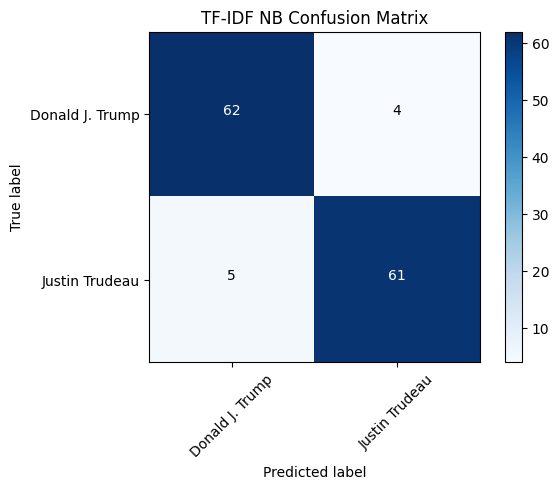

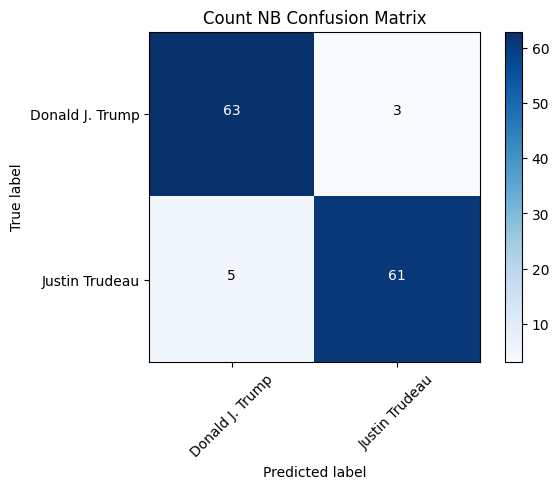

In [10]:
# Calculate the confusion matrices for the tfidf_nb model and count_nb models
tfidf_nb_cm = confusion_matrix(y_test, tfidf_nb_pred)
count_nb_cm = confusion_matrix(y_test, count_nb_pred)

# Plot the tfidf_nb_cm confusion matrix
plot_confusion_matrix(tfidf_nb_cm, classes=tfidf_nb.classes_, title="TF-IDF NB Confusion Matrix")

# Plot the count_nb_cm confusion matrix without overwriting the first plot
plot_confusion_matrix(count_nb_cm, classes=count_nb.classes_, title="Count NB Confusion Matrix", figure=1)

## 6. Пробуем другой классификатор: LinearSVC
<p>Итак, байесовская модель имеет только одно различие в прогнозировании между TF-IDF и векторизаторами подсчета — довольно впечатляюще! Интересно, что возникает некоторая путаница, когда прогнозируемая метка — Трамп, а фактический твиттер — Трюдо. Если бы мы собирались использовать эту модель, мы бы хотели исследовать, какие токены вызывают путаницу, чтобы улучшить модель.</p>
<p>Теперь, когда мы увидели, на что способна байесовская модель, как насчет того, чтобы попробовать другой подход? <a href="https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html">LinearSVC</a> — еще один популярный выбор для классификации текста. Посмотрим, улучшит ли его использование с векторами TF-IDF точность классификатора</p>



LinearSVC Score:   0.924
Confusion matrix, without normalization


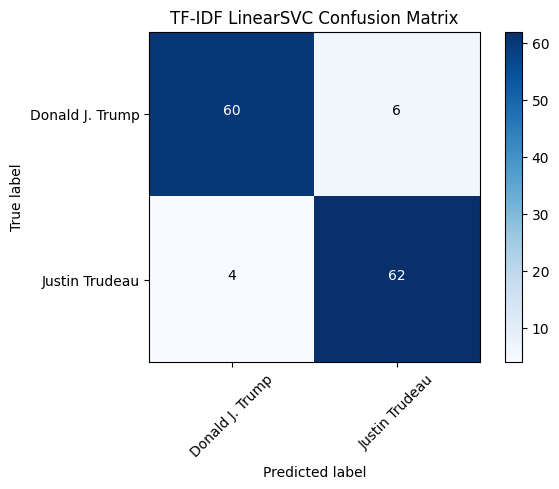

In [11]:
# Create a LinearSVM model
tfidf_svc = LinearSVC(random_state=53)

# ... Train your model here ...
tfidf_svc.fit(tfidf_train, y_train)
# Run predict on your tfidf test data to get your predictions
tfidf_svc_pred = tfidf_svc.predict(tfidf_test)

# Calculate your accuracy using the metrics module
tfidf_svc_score = metrics.accuracy_score(y_test, tfidf_svc_pred)

print("LinearSVC Score:   %0.3f" % tfidf_svc_score)

# Calculate the confusion matrices for the tfidf_svc model
svc_cm = confusion_matrix(y_test, tfidf_svc_pred)

# Plot the confusion matrix using the plot_confusion_matrix function
plot_confusion_matrix(svc_cm, classes=tfidf_svc.classes_, title="TF-IDF LinearSVC Confusion Matrix")

## 7. Анализ лучшей модели
<p>Модель LinearSVC даже лучше, чем мультиномиальная байесовская. С помощью матрицы несоответствий мы видим, что, хотя все еще есть некоторая путаница, когда твиты Трюдо классифицируются как твиты Трампа, уровень ложных срабатываний лучше, чем в предыдущей модели. Итак, у нас есть производительная модель.</p>
<p>Мы могли бы продолжить настройку и улучшение всех предыдущих моделей, узнав больше об оптимизации параметров или применив более совершенную предварительную обработку твитов. </p>
<p>Теперь посмотрим, чему научилась модель. Используя LinearSVC Classifier с двумя классами (Трамп и Трюдо), мы можем отсортировать признаки (токены) по их весу и увидеть самые важные токены как для Трампа, так и для Трюдо. Какие слова больше всего похожи на Трампа или Трюдо? Узнала ли модель что-то полезное, чтобы различать этих двух политиков? </p>


!!!!!!!Я не имею понятия, что за datasets.helper_functions и откуда это, поэтому я сделала свою функцию для анализа важных признаков. По той же причине, выше, в confussion matrix, "from utils.helper_functions import plot_confusion_matrix" было заменено на confusion_matrix из scikit-learn

In [12]:
#from datasets.helper_functions import plot_and_return_top_features

# Import pprint from pprint
#from pprint import pprint

# Get the top features using the plot_and_return_top_features function and your top model and tfidf vectorizer
#top_features = plot_and_return_top_features(tfidf_svc, tfidf_vectorizer)

# pprint the top features
#pprint(top_features)


Анализ важнфх признаков:
LinearSVC:
Топ {top_features} признаков для Трюдо (отрицательные веса):
  great           | вес:  -1.2048
  just            | вес:  -0.8537
  thank           | вес:  -0.8386
  america         | вес:  -0.7485
  united          | вес:  -0.6543
  collusion       | вес:  -0.6518
  korea           | вес:  -0.6100
  russia          | вес:  -0.5956
  president       | вес:  -0.5827
  wonderful       | вес:  -0.5742
  tax             | вес:  -0.5643
  people          | вес:  -0.5276
  happy           | вес:  -0.5031
  administration  | вес:  -0.4901
  attack          | вес:  -0.4864
Топ {top_features} признаков для Трампа (положительные веса):
  rt              | вес:   1.8153
  canada          | вес:   1.2221
  la              | вес:   0.9457
  et              | вес:   0.9042
  pour            | вес:   0.8489
  les             | вес:   0.7983
  seamusoregan    | вес:   0.7979
  nous            | вес:   0.7683
  today           | вес:   0.7359
  val_plante      | вес: 

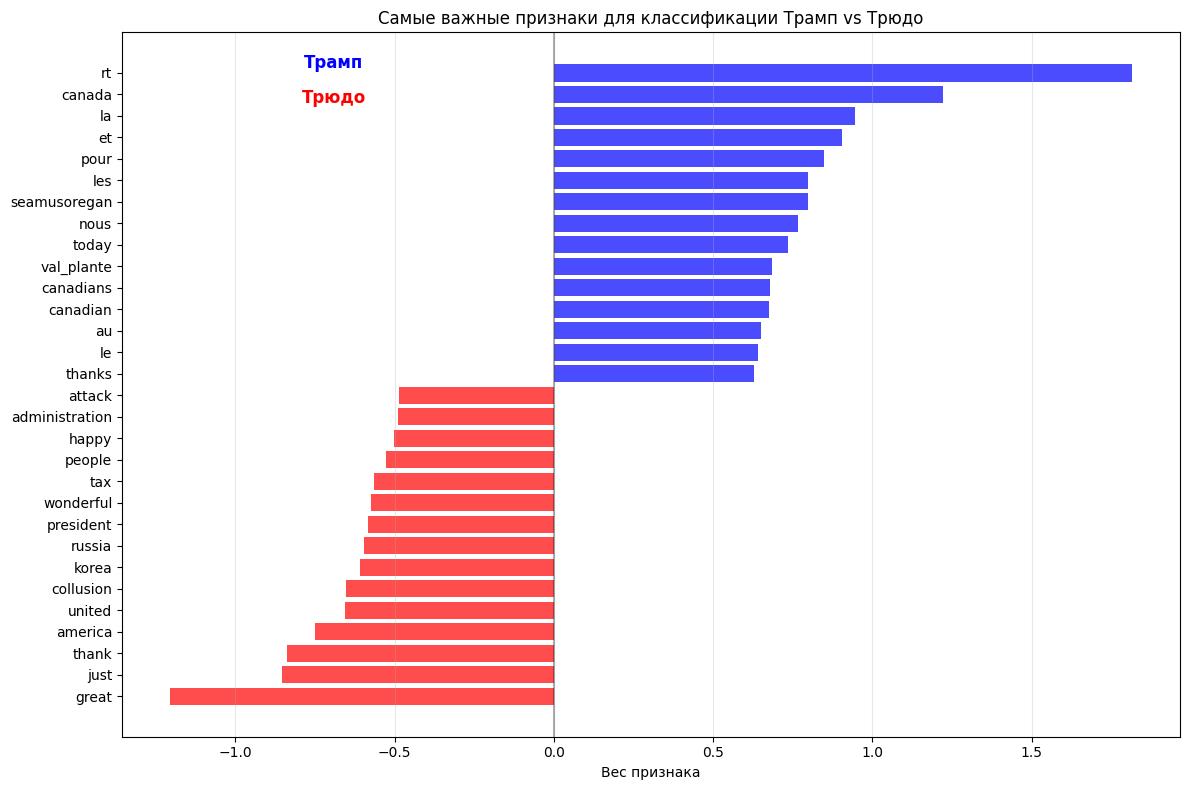

[(np.float64(-1.2047688511800037), 'great'),
 (np.float64(-0.8536613171059494), 'just'),
 (np.float64(-0.8385646120793386), 'thank'),
 (np.float64(-0.7484585074322693), 'america'),
 (np.float64(-0.6543002510769188), 'united'),
 (np.float64(-0.6518070855935311), 'collusion'),
 (np.float64(-0.6100312647727165), 'korea'),
 (np.float64(-0.5955761543267256), 'russia'),
 (np.float64(-0.5826972919766654), 'president'),
 (np.float64(-0.5741935189960062), 'wonderful'),
 (np.float64(-0.5642640045249117), 'tax'),
 (np.float64(-0.5275747527144196), 'people'),
 (np.float64(-0.5031271351469091), 'happy'),
 (np.float64(-0.4901024865203583), 'administration'),
 (np.float64(-0.4863915751046238), 'attack'),
 (np.float64(0.629082372020817), 'thanks'),
 (np.float64(0.6413379557647887), 'le'),
 (np.float64(0.6518771114926031), 'au'),
 (np.float64(0.6757736734786692), 'canadian'),
 (np.float64(0.6774586706385802), 'canadians'),
 (np.float64(0.6842146102256834), 'val_plante'),
 (np.float64(0.7359231059220745

In [13]:
from pprint import pprint

def analyze_top_features(classifier, vectorizer, top_features=20): #Анализирует и выводит самые важные признаки для классификации
    feature_names = vectorizer.get_feature_names_out()
    coef = classifier.coef_[0]
    
    feature_weights = sorted(zip(coef, feature_names), key=lambda x: x[0])
    
    top_trudeau = feature_weights[:top_features]
    top_trump = feature_weights[-top_features:]
    top_trump.reverse()  # Чтобы начать с самых важных
    
    print("Топ {top_features} признаков для Трюдо (отрицательные веса):")
    for weight, feature in top_trudeau:
        print(f"  {feature:15} | вес: {weight:8.4f}")
    
    print("Топ {top_features} признаков для Трампа (положительные веса):")
    for weight, feature in top_trump:
        print(f"  {feature:15} | вес: {weight:8.4f}")
    
    return top_trudeau + top_trump

def plot_top_features(classifier, vectorizer, top_features=20):
    feature_names = vectorizer.get_feature_names_out()
    coef = classifier.coef_[0]
    
    # Получить признаки
    feature_weights = sorted(zip(coef, feature_names), key=lambda x: x[0])
    top_negative = feature_weights[:top_features]
    top_positive = feature_weights[-top_features:]
    
    # Объединяет и убирает дубликаты
    top_features_combined = []
    seen = set()
    
    for weight, feature in top_negative + top_positive:
        if feature not in seen:
            top_features_combined.append((weight, feature))
            seen.add(feature)
    
    top_features_combined.sort(key=lambda x: x[0])# Сортировка по весу
    
    plt.figure(figsize=(12, 8))
    colors = ['red' if weight < 0 else 'blue' for weight, feature in top_features_combined]
    features = [feature for weight, feature in top_features_combined]
    weights = [weight for weight, feature in top_features_combined]
    
    y_pos = np.arange(len(features))
    
    plt.barh(y_pos, weights, color=colors, alpha=0.7)
    plt.yticks(y_pos, features)
    plt.xlabel('Вес признака')
    plt.title('Самые важные признаки для классификации Трамп vs Трюдо')
    plt.grid(axis='x', alpha=0.3)
    
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.text(0.2, 0.95, 'Трамп', transform=plt.gca().transAxes, color='blue', 
             fontsize=12, fontweight='bold', ha='center')
    plt.text(0.2, 0.90, 'Трюдо', transform=plt.gca().transAxes, color='red',
             fontsize=12, fontweight='bold', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    return top_features_combined

print("Анализ важнфх признаков:")
print("LinearSVC:")

top_features = analyze_top_features(tfidf_svc, tfidf_vectorizer, top_features=15)

plot_top_features(tfidf_svc, tfidf_vectorizer, top_features=15)

## 8. Бонус: сможете ли вы написать твит Трампа или Трюдо?
<p>Итак, чему научилась наша модель?</p>
<p>Напишите собственный твит, используя полученные знания, чтобы обмануть модель! Используйте напечатанный список или график выше, чтобы сделать некоторые выводы о том, какие слова классифицируют ваш текст как Трампа или Трюдо. Сможете ли вы обмануть модель, заставив ее думать, что вы Трамп или Трюдо?</p>




In [14]:
# Напишите два твита, один из которых вы хотите классифицировать как твит Трампа, а другой как Трюдо.
trump_tweet = "Make America Great Again!"
trudeau_tweet = "Proud of our diverse and inclusive Canada."

# Векторизуем каждый твит с помощью метода transform векторизатора TF-IDF
# Примечание: `transform` требует строку в объекте списка
trump_tweet_vectorized = tfidf_vectorizer.transform([trump_tweet])
trudeau_tweet_vectorized = tfidf_vectorizer.transform([trudeau_tweet])

# Call the predict method on your vectorized tweets
trump_tweet_pred = tfidf_svc.predict(trump_tweet_vectorized)
trudeau_tweet_pred = tfidf_svc.predict(trudeau_tweet_vectorized)

print("Predicted Trump tweet", trump_tweet_pred)
print("Predicted Trudeau tweet", trudeau_tweet_pred)

Predicted Trump tweet ['Donald J. Trump']
Predicted Trudeau tweet ['Justin Trudeau']


<p>Дальнейшая работа над этим набором данных  может включать:</p>
<ul>
<li>Добавьте дополнительную предварительную обработку (например, удалите URL-адреса или французские стоп-слова) и посмотрите на результаты</li>
<li>Используйте GridSearchCV для улучшения ваших байесовских и линейных SVC-моделей, найдя оптимальные параметры</li>
</ul>